![logo](../LogoLine_horizon_C3S.png)

# Reproducing the single-system graphical products for additional variables

## Introduction

This Jupyter Notebook shows how the products shown in the C3S seasonal  __[graphical products](https://climate.copernicus.eu/charts/packages/c3s_seasonal/)__ can be calculated from data in the __[Climate Data Store](#configuration)__ (CDS), and plotted. The C3S seasonal graphical and data products are described in this __[documentation page](https://confluence.ecmwf.int/display/CKB/C3S+seasonal+forecast+product+descriptions)__. 

This example code can be used as the basis for creating graphical products which are not part of the C3S suite. In this example we look at monthly mean daily minimum temperature forecasts (for one system, ECMWF System 51), which is a variable available in the CDS dataset but not the graphical products. A 'tercile summary' is computed from tercile probabilities. An ensemble mean anomaly is also calculated and plotted with significance testing applied. This will be used in a further example to create multi-system combinations.

1. [Configuration](#configuration)
2. [CDS API requests](#cds-api-requests)
3. [Load forecast and hindcast data](#load-forecast-and-hindcast-data)
4. [Produce tercile summary](#produce-tercile-summary) 
5. [Plot tercile summary](#plot-tercile-summary) 
6. [Produce ensemble mean anomaly](#produce-ensemble-mean-anomaly)
7. [Plot ensemble mean anomaly](#plot-ensemble-mean-anomaly)


## Configuration

Here we set which variable(s) will be downloaded, for which C3S seasonal system. We also set which forecast date we will create a forecast for, and which hindcast period to use (which will be used to calculate the terciles and anomalies). **Note that the URL and KEY need to be filled in with the details from your CDS account, and the [cdsapi package](https://cds.climate.copernicus.eu/how-to-api) needs to be installed.**

<div class="alert alert-block alert-warning">
<b>Note:</b> To create multi-system combinations in the related Notebook this code needs to be run for each of the system to be included. Simply edit the `prov = 'ecmf.s51' ` line to retrieve and process other systems, or add a loop which runs over multiple systems.
</div>

Import required modules and configure CDS API key and client.

In [ ]:
# import required modules
import cdsapi
import os
import xarray as xr
import numpy as np
import pandas as pd

# Date and time related libraries
from dateutil.relativedelta import relativedelta
from calendar import monthrange
import datetime

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# config to avoid issues saving to netcdf if needed
os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

# Need to leave this blank and the user needs to enter their url and key here
URL = 'https://cds.climate.copernicus.eu/api'
KEY = '' # INSERT CDS KEY HERE
c = cdsapi.Client(url=URL, key=KEY)

Define a library of provider details and variables of interest (only `tmin` is used here, but this will be compared to `tmean` and `tmax` in another Notebook).

In [18]:
# library of C3S systems and useful parameters
# max_hc and max_fc represent the number of members to be considered (the number index starts from 0, the most recent)
providers = {
    'ecmf.s51': {'cds_name': 'ecmwf', 'plot_name': 'ECMWF', 'plot_system': 'SEAS5', 'cds_system': '51',
                 'lagged': False},
    'lfpw.s8': {'cds_name': 'meteo_france', 'plot_name': 'Météo-France', 'plot_system': 'System 8', 'cds_system': '8',
                'lagged': False},
    'egrr.s602': {'cds_name': 'ukmo', 'plot_name': 'Met Office', 'plot_system': 'GloSea6', 'cds_system': '602',
                  'lagged': True, 'max_hc': 50, 'max_fc': 'none'},
    'edzw.s21': {'cds_name': 'dwd', 'plot_name': 'DWD', 'plot_system': 'GCFS2.1', 'cds_system': '21',
                 'lagged': False},
    'cmcc.s35': {'cds_name': 'cmcc', 'plot_name': 'CMCC', 'plot_system': 'SPS3.5', 'cds_system': '35',
                 'lagged': False},
    'kwbc.s2': {'cds_name': 'ncep', 'plot_name': 'NCEP', 'plot_system': 'CFSv2', 'cds_system': '2',
                'lagged': True, 'max_hc': 20, 'max_fc': 52},
    'rjtd.s3': {'cds_name': 'jma', 'plot_name': 'JMA', 'plot_system': 'CPS3', 'cds_system': '3',
                'lagged': True, 'max_hc': 'none', 'max_fc': 55},
    'cwao.s2': {'cds_name': 'eccc', 'plot_name': 'ECCC', 'plot_system': 'CanCM4i', 'cds_system': '2',
                'lagged': False},
    'cwao.s3': {'cds_name': 'eccc', 'plot_name': 'ECCC', 'plot_system': 'GEM5-NEMO', 'cds_system': '3',
                'lagged': False},
}

# some options for variables
vars = {
    'tmean': {'plot_name': 'daily mean T2m', 'cds_name': '2m_temperature'}, 
    'tmax' : {'plot_name': 'daily max T2m', 'cds_name': 'maximum_2m_temperature_in_the_last_24_hours'},
    'tmin' : {'plot_name': 'daily min T2m', 'cds_name': 'minimum_2m_temperature_in_the_last_24_hours'}
}

Set request details to be used by the API requests below. Also define a directory and structure where the data will be saved.

In [19]:
# select the provider from the dictionary above, 
# and the associated fields needed for the CDS API request and loading the data
prov = 'ecmf.s51'  
centre = providers[prov]['cds_name']
version = providers[prov]['cds_system']
lagged = providers[prov]['lagged']

# define some other parameters for the data request
fc_yr = '2024'
st_mon = '02'

var = 'tmin'  # select a variable from the dictionary above
var_str = vars[var]['plot_name']   # for plotting
cds_var_name = vars[var]['cds_name']  # for the CDS request

lt_mons = [1, 2, 3, 4, 5, 6]  # cover all lead months when plotting month by month
hc_years = '1993_2016'  # string to print the hindcast period, and label the file

# data path in cwd 
data_path = os.sep.join(['data', centre, version])
try:
   os.makedirs(data_path)
except FileExistsError:
   # directory already exists
   pass

## CDS API requests

Here we request the desired hindcast and forecast data in GRIB format using the CDS API, and save it within a folder 'data' in the current working directory, organised by originating centre and forecast system. For this example, the CDS API keywords used are:

**Format**: `Grib` <br>
**Variable**: `minimum_2m_temperature_in_the_last_24_hours` *set via 'cds_var_name'* <br>
**Originating centre**: `ECMWF` *set via 'centre'* <br>
**System**: `51` *this refers to SEAS5 system 51, set via 'version'* <br>
**Product type**: `Monthly mean` *all ensemble members will be retrieved* <br>
**Year**: `1993 to 2016` *for the hindcast* `2024` *for the forecast, set via 'hc_years' and 'fc_year'* <br>
**Month**: `02` *February, set via 'st_mon'* <br>
**Leadtime month**: `1 to 6` *all lead months available, February to July in this case*

In [ ]:
#HINDCAST REQUEST - 1993-2016
c.retrieve(
    'seasonal-monthly-single-levels',
    {
        'format': 'grib',
        'variable': cds_var_name,
        'originating_centre': centre,
        'system': version,
        'product_type': 'monthly_mean',
        'year': [
            '1993', '1994', '1995',
            '1996', '1997', '1998',
            '1999', '2000', '2001',
            '2002', '2003', '2004',
            '2005', '2006', '2007',
            '2008', '2009', '2010',
            '2011', '2012', '2013',
            '2014', '2015', '2016',
        ],
        'month': [st_mon],
        'leadtime_month': lt_mons
    },
    data_path + '/{}_mm_{}_{}_{}_{}.grib'.format(var, centre, version, hc_years, st_mon))

In [ ]:
#FORECAST REQUEST
c.retrieve(
    'seasonal-monthly-single-levels',
    {
        'format': 'grib',
        'variable': [cds_var_name],
        'originating_centre': centre,
        'system': version,
        'product_type': 'monthly_mean',
        'year': [fc_yr],
        'month': [st_mon],
        'leadtime_month': lt_mons
    },
    data_path + '/{}_mm_{}_{}_{}_{}.grib'.format(var, centre, version, fc_yr, st_mon))

## Load forecast and hindcast data



First, prepare for the lagged start time coordinates, where careful treatment is required when loading the data into xarray (if needed).

In [22]:
# For the re-shaping of time coordinates in xarray.Dataset we need to select the right one 
#  -> burst mode ensembles (e.g. ECMWF SEAS5) use "time". 
#  -> lagged start ensembles (e.g. MetOffice GloSea6) use "indexing_time" (see documentation about nominal start date)
if lagged:
    st_dim_name = 'indexing_time'
else:
    st_dim_name = 'time'

Now load the hindcast data as an xarray object using [cfgrib](https://github.com/ecmwf/cfgrib):

In [23]:
# load hindcasts
hc_path = data_path + '/' + '_'.join([var, 'mm', centre, version, hc_years, st_mon]) + '.grib'
hcst = xr.open_dataarray(hc_path, engine='cfgrib',
                         backend_kwargs=dict(time_dims=('forecastMonth', st_dim_name)))
# rename indexing time or time to start date
hcst = hcst.rename({st_dim_name: 'start_date', 'longitude': 'lon', 'latitude': 'lat'})
# roll longitude
hcst = hcst.assign_coords(lon=(((hcst.lon + 180) % 360) - 180)).sortby('lon')
hcst

<xarray.DataArray 'mn2t24' (number: 25, forecastMonth: 6, start_date: 24,
                            lat: 180, lon: 360)> Size: 933MB
[233280000 values with dtype=float32]
Coordinates:
  * number         (number) int64 200B 0 1 2 3 4 5 6 7 ... 18 19 20 21 22 23 24
  * forecastMonth  (forecastMonth) int64 48B 1 2 3 4 5 6
  * start_date     (start_date) datetime64[ns] 192B 1993-02-01 ... 2016-02-01
    surface        float64 8B ...
  * lat            (lat) float64 1kB 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon            (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes: (12/31)
    GRIB_paramId:                             52
    GRIB_dataType:                            fcmean
    GRIB_numberOfPoints:                      64800
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           mn2t24
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                Minimum temperature at 2 metres...
    units:                                    K
    standard_name:                            unknown

Now load the forecast data in the same manner.

In [24]:
fc_path = data_path + '/' + '_'.join([var, 'mm', centre, version, fc_yr, st_mon]) + '.grib'
fcst = xr.open_dataarray(fc_path, engine='cfgrib',
                         backend_kwargs=dict(time_dims=('forecastMonth', st_dim_name)))
# rename indexing time or time to start date
fcst = fcst.rename({st_dim_name: 'start_date', 'longitude': 'lon', 'latitude': 'lat'})
# roll longitude
fcst = fcst.assign_coords(lon=(((fcst.lon + 180) % 360) - 180)).sortby('lon')
fcst

<xarray.DataArray 'mn2t24' (number: 51, forecastMonth: 6, lat: 180, lon: 360)> Size: 79MB
[19828800 values with dtype=float32]
Coordinates:
  * number         (number) int64 408B 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 48B 1 2 3 4 5 6
    start_date     datetime64[ns] 8B ...
    surface        float64 8B ...
  * lat            (lat) float64 1kB 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon            (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Attributes: (12/31)
    GRIB_paramId:                             52
    GRIB_dataType:                            fcmean
    GRIB_numberOfPoints:                      64800
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           mn2t24
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                Minimum temperature at 2 metres...
    units:                                    K
    standard_name:                            unknown

For the forecast array, we add a 'valid time' coordinate, which will be useful for labelling the plots later. 

In [25]:
valid_time = [pd.to_datetime(fcst.start_date.values) + relativedelta(months=fcmonth-1) for fcmonth in fcst.forecastMonth]
fcst = fcst.assign_coords(valid_time=('forecastMonth',valid_time))
fcst

<xarray.DataArray 'mn2t24' (number: 51, forecastMonth: 6, lat: 180, lon: 360)> Size: 79MB
[19828800 values with dtype=float32]
Coordinates:
  * number         (number) int64 408B 0 1 2 3 4 5 6 7 ... 44 45 46 47 48 49 50
  * forecastMonth  (forecastMonth) int64 48B 1 2 3 4 5 6
    start_date     datetime64[ns] 8B 2024-02-01
    surface        float64 8B ...
  * lat            (lat) float64 1kB 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon            (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    valid_time     (forecastMonth) datetime64[ns] 48B 2024-02-01 ... 2024-07-01
Attributes: (12/31)
    GRIB_paramId:                             52
    GRIB_dataType:                            fcmean
    GRIB_numberOfPoints:                      64800
    GRIB_typeOfLevel:                         surface
    GRIB_stepUnits:                           1
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_shortName:                           mn2t24
    GRIB_totalNumber:                         0
    GRIB_units:                               K
    long_name:                                Minimum temperature at 2 metres...
    units:                                    K
    standard_name:                            unknown

### Select qualifying ensemble members

Here we select which ensemble members to use. For some lagged start systems a subset of the available ensemble members are used in the graphical products, as described in the __[documentation](https://confluence.ecmwf.int/display/CKB/Summary+of+available+data#:~:text=per%20forecast%20system-,Nominal%20Start%20Dates,-For%20systems%20with)__. 

In [26]:
# for some lagged systems sub-select 'qualifying' ensemble members used in the C3S graphical products
if lagged:
    max_hc = providers[prov]['max_hc']
    max_fc = providers[prov]['max_fc']
    if isinstance(max_hc, int):
        hcst = hcst.sel(number=slice(None, max_hc-1))
    if isinstance(max_fc, int):
        fcst = fcst.sel(number=slice(None, max_fc-1))

## Produce tercile summary

### Calculate tercile summary from hindcasts

The first step of calculating probabilities for the tercile summary is to calculate the terciles from the hindcast period.

In [27]:
quantiles = [1. / 3., 2. / 3.]
hcst_qbnds = hcst.quantile(quantiles, ['start_date', 'number'])
hcst_qbnds

<xarray.DataArray 'mn2t24' (quantile: 2, forecastMonth: 6, lat: 180, lon: 360)> Size: 6MB
array([[[[244.33795675, 244.3340505 , 244.3294932 , ..., 244.33822123,
          244.34056091, 244.33990987],
         [244.26223246, 244.2658844 , 244.26529948, ..., 244.26017761,
          244.26213074, 244.26158142],
         [244.3015035 , 244.29098002, 244.28975423, ..., 244.33988444,
          244.32062276, 244.30947367],
         ...,
         [237.04042562, 237.21615092, 237.3900706 , ..., 236.69554647,
          236.79473877, 236.89592997],
         [234.16823832, 234.20966085, 234.24293518, ..., 234.05273946,
          234.08274333, 234.1269633 ],
         [233.24236552, 233.25799052, 233.27361552, ..., 233.18774923,
          233.20597839, 233.22408549]],

        [[245.56556702, 245.55254618, 245.53952535, ..., 245.58742269,
          245.58509827, 245.57663472],
         [245.5316925 , 245.52070109, 245.51565043, ..., 245.57148743,
          245.5621287 , 245.5460968 ],
         [245.55889893, 245.56478373, 245.53250122, ..., 245.61849467,
          245.59778849, 245.57480876],
...
         [225.34759521, 225.58892822, 225.82394918, ..., 224.80664062,
          224.97796631, 225.15042114],
         [221.08680725, 221.15615845, 221.21076457, ..., 220.89515177,
          220.96019491, 221.0200297 ],
         [219.65723165, 219.67907206, 219.70055644, ..., 219.59383647,
          219.61271667, 219.63448588]],

        [[273.45979818, 273.46118164, 273.46191406, ..., 273.46000163,
          273.45887248, 273.45979818],
         [273.48677572, 273.48613485, 273.48429362, ..., 273.49622599,
          273.49405924, 273.48976644],
         [273.51208496, 273.50508626, 273.49625651, ..., 273.52081299,
          273.5201416 , 273.51790365],
         ...,
         [223.76084391, 224.02160136, 224.28734843, ..., 223.19769287,
          223.36869812, 223.53948975],
         [219.58465068, 219.65275574, 219.71683757, ..., 219.36538696,
          219.4367218 , 219.5164388 ],
         [218.15458171, 218.16595459, 218.1831665 , ..., 218.1204834 ,
          218.13516235, 218.14623006]]]])
Coordinates:
  * forecastMonth  (forecastMonth) int64 48B 1 2 3 4 5 6
  * lat            (lat) float64 1kB 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon            (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * quantile       (quantile) float64 16B 0.3333 0.6667

### Compute forecast probabilities

Now we calculate the forecast probabilities by counting the number of ensemble members above and below the upper and lower quartiles.

In [28]:
fc_ens = fcst.sizes['number']
print(" ####### FC ENS SIZE ####### ")
print(fc_ens)
above = fcst.where(fcst > hcst_qbnds.sel(quantile=2. / 3.)).count('number')
below = fcst.where(fcst < hcst_qbnds.sel(quantile=1. / 3.)).count('number')

 ####### FC ENS SIZE ####### 
51


Now we calculate probabilites for each tercile category (above, below, and normal), and combine them to create a single array to use for plotting the tercile summary.

In [29]:
P_above = 100. * (above / float(fc_ens))
P_below = 100. * (below / float(fc_ens))
P_normal = 100. - (P_above + P_below)

a = P_above.where(P_above > np.maximum(40. + 0 * P_above, P_below), 0.)
b = P_below.where(P_below > np.maximum(40. + 0 * P_below, P_above), 0.)
P_summary = a - b

P_summary

<xarray.DataArray 'mn2t24' (forecastMonth: 6, lat: 180, lon: 360)> Size: 3MB
array([[[100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        [100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        [100.        , 100.        , 100.        , ..., 100.        ,
         100.        , 100.        ],
        ...,
        [ 58.82352941,  58.82352941,  58.82352941, ...,  56.8627451 ,
          56.8627451 ,  58.82352941],
        [ 62.74509804,  62.74509804,  62.74509804, ...,  64.70588235,
          64.70588235,  62.74509804],
        [ 52.94117647,  52.94117647,  52.94117647, ...,  52.94117647,
          52.94117647,  52.94117647]],

       [[ 72.54901961,  72.54901961,  72.54901961, ...,  72.54901961,
          72.54901961,  72.54901961],
        [ 78.43137255,  78.43137255,  78.43137255, ...,  80.39215686,
          80.39215686,  78.43137255],
        [ 76.47058824,  76.47058824,  76.47058824, ...,  76.47058824,
          76.47058824,  76.47058824],
...
        [ 47.05882353,  50.98039216,  49.01960784, ...,  49.01960784,
          47.05882353,  47.05882353],
        [ 50.98039216,  49.01960784,  49.01960784, ...,  49.01960784,
          49.01960784,  50.98039216],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ]],

       [[  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [  0.        ,   0.        ,   0.        , ...,   0.        ,
           0.        ,   0.        ],
        [ 41.17647059,   0.        ,  41.17647059, ...,   0.        ,
           0.        ,  41.17647059],
        ...,
        [ 50.98039216,  50.98039216,  52.94117647, ...,  50.98039216,
          50.98039216,  50.98039216],
        [ 54.90196078,  54.90196078,  56.8627451 , ...,  56.8627451 ,
          56.8627451 ,  56.8627451 ],
        [ 49.01960784,  49.01960784,  49.01960784, ...,  49.01960784,
          49.01960784,  49.01960784]]])
Coordinates:
  * forecastMonth  (forecastMonth) int64 48B 1 2 3 4 5 6
    start_date     datetime64[ns] 8B 2024-02-01
    surface        float64 8B 0.0
  * lat            (lat) float64 1kB 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon            (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    valid_time     (forecastMonth) datetime64[ns] 48B 2024-02-01 ... 2024-07-01

## Plot tercile summary

### Plot setup

Here we set up a directory for saving the plots, and set up some plot parameters.

In [31]:
# levels to use when shading the plot, and corresponding colours
contour_levels = [-100., -70., -60., -50., -40., 40., 50., 60., 70., 100.]
contour_colours = ["navy", "blue", "deepskyblue", "cyan", "white", "yellow", "orange", "orangered", "tab:red"]

### Make a plot for each lead month

Note: the C3S graphical products are contour plots rather than the grid mesh plots below

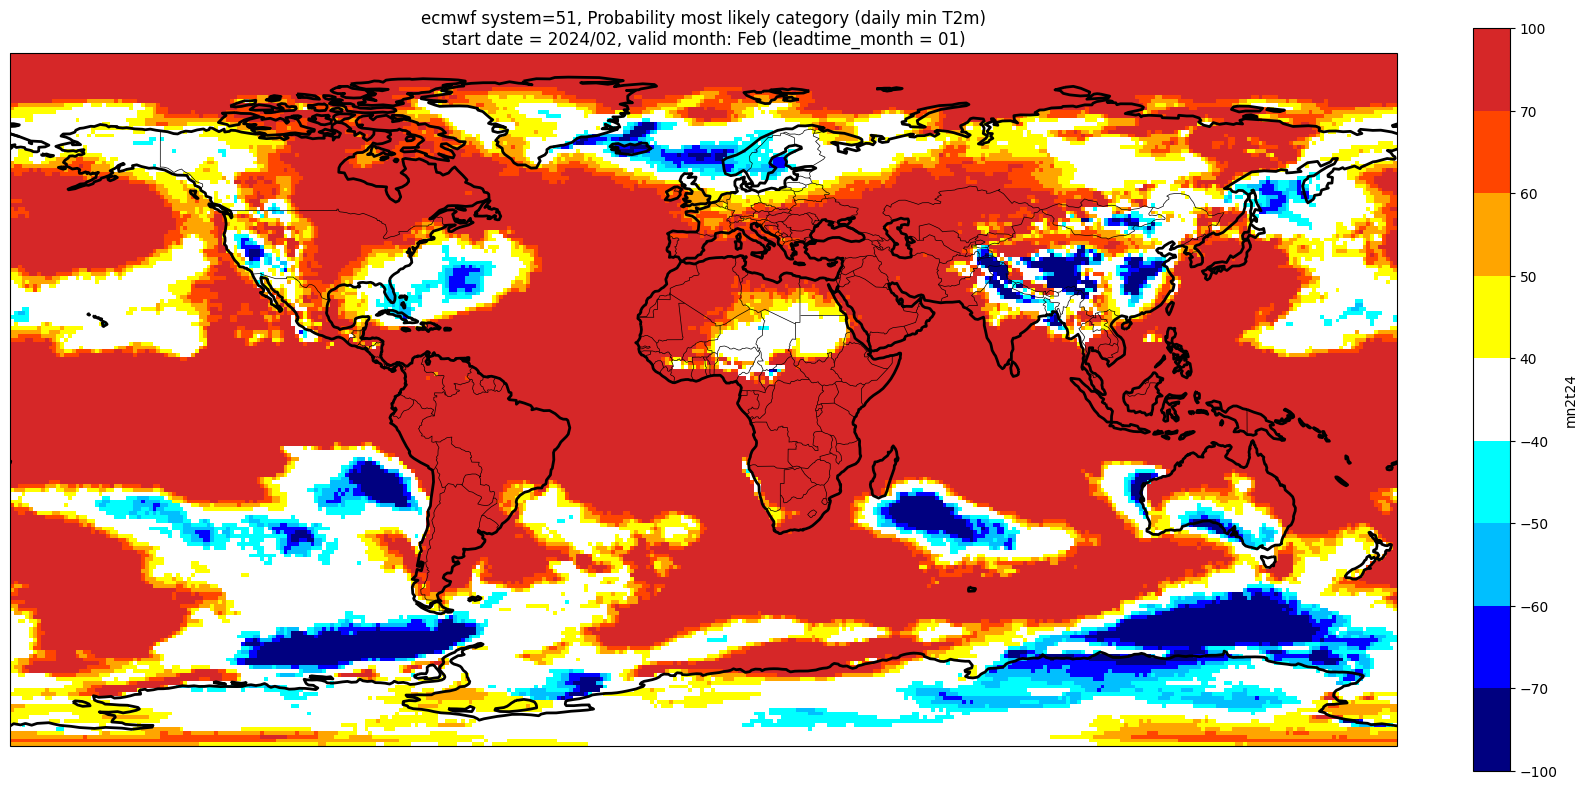

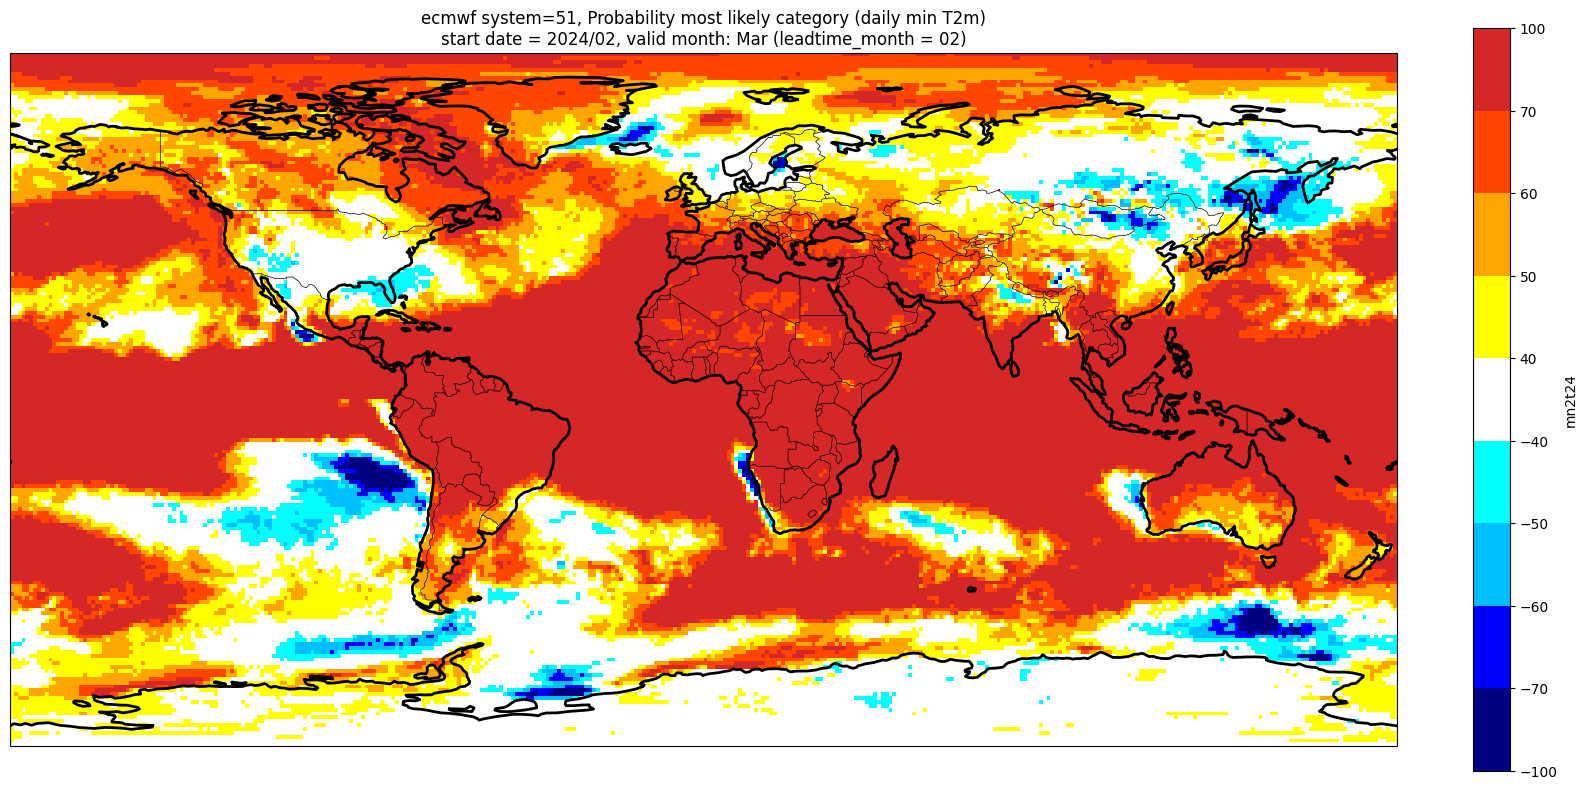

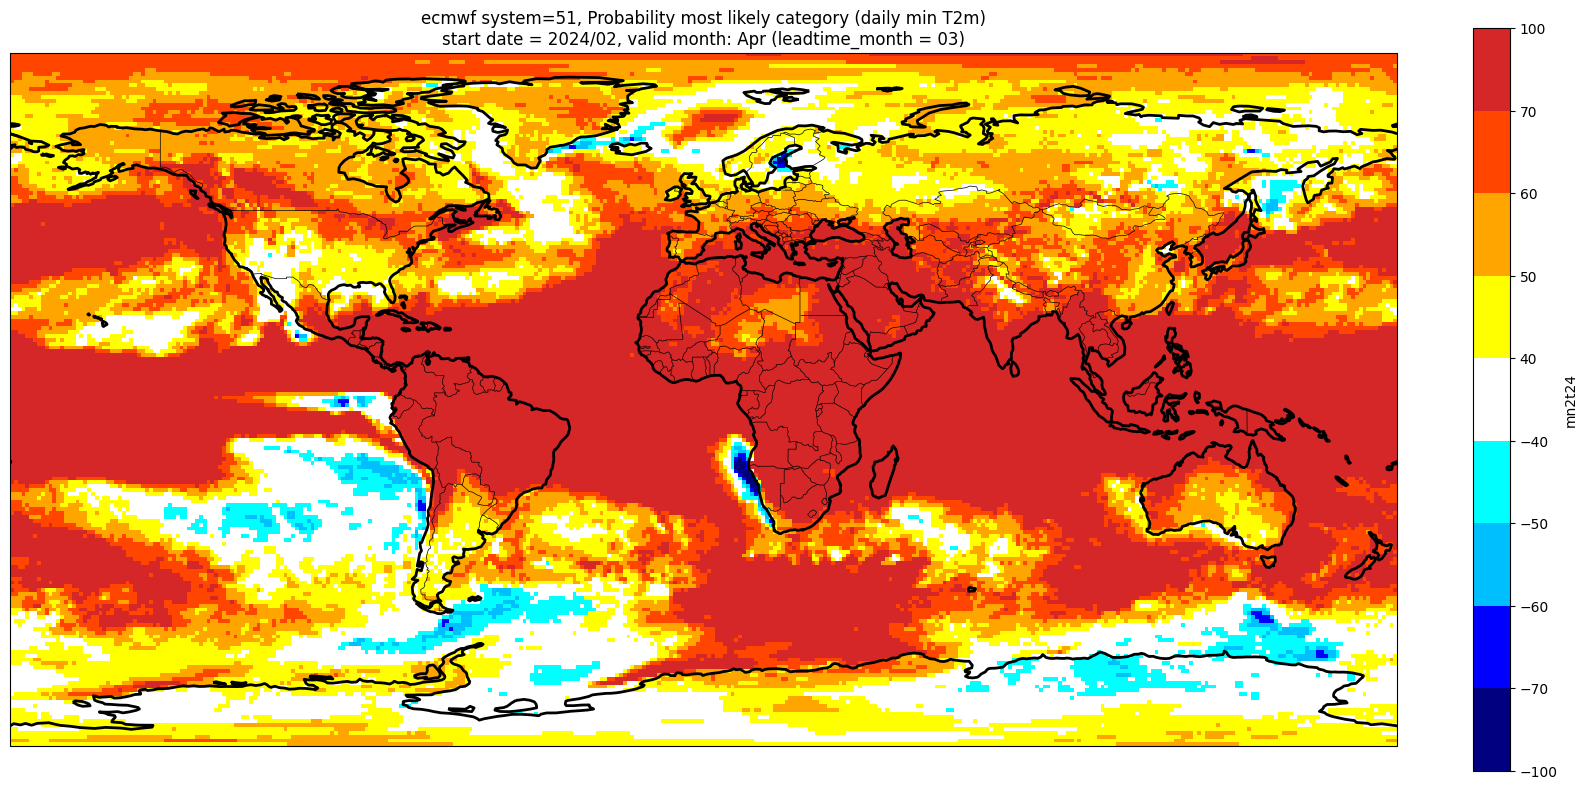

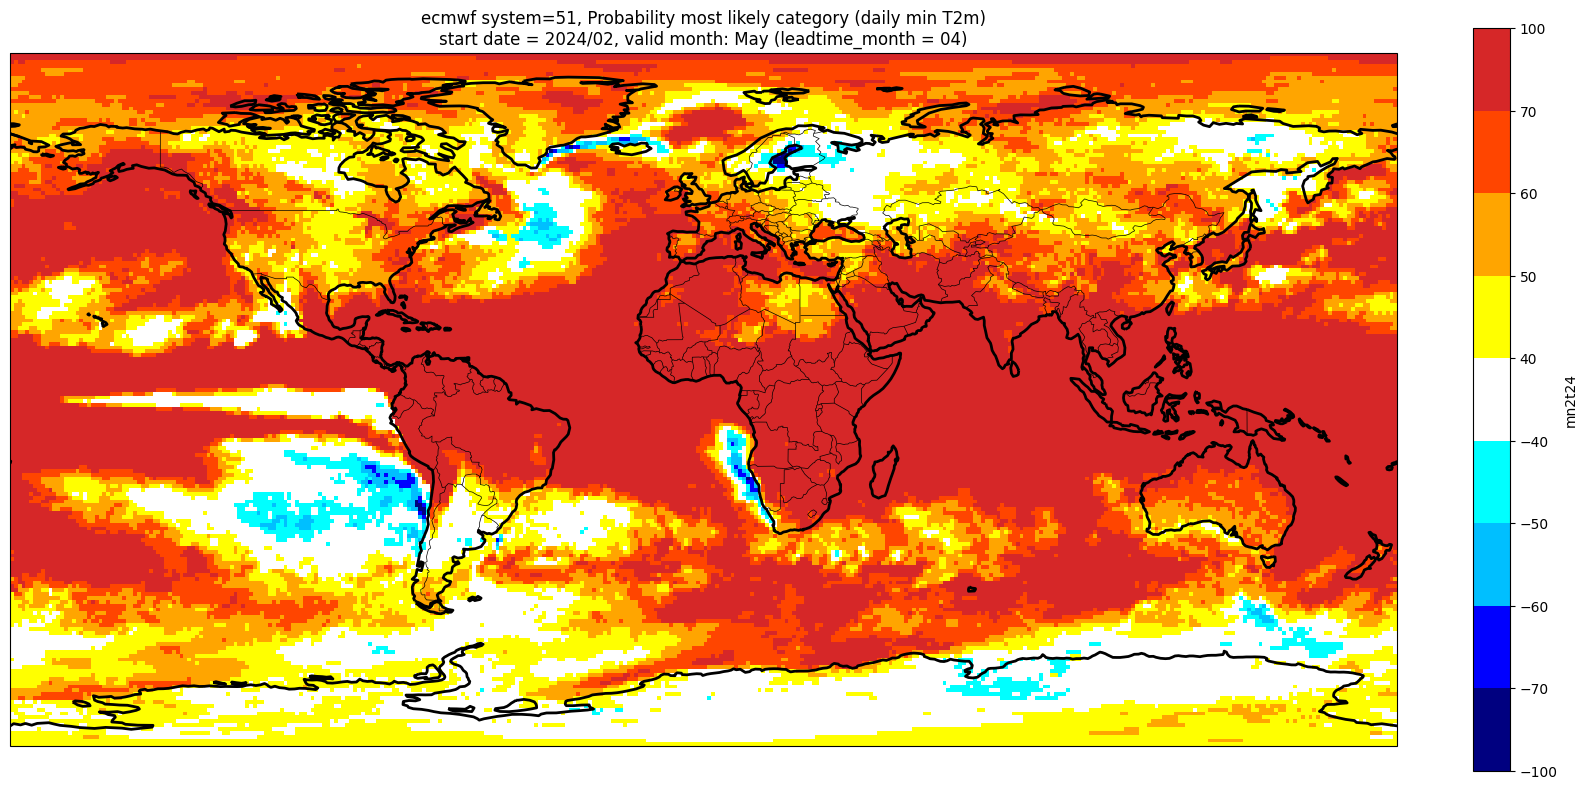

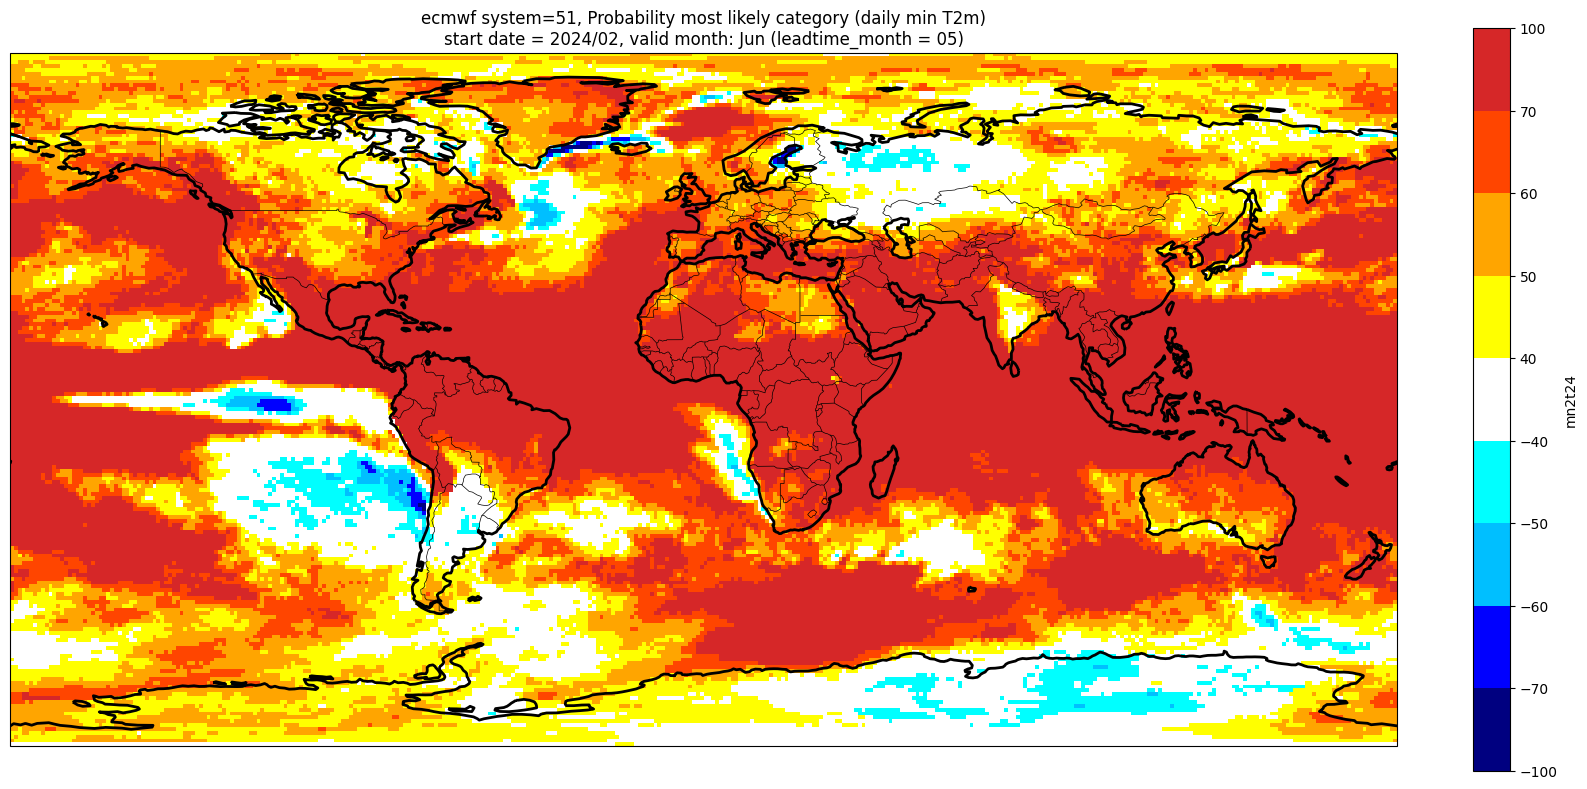

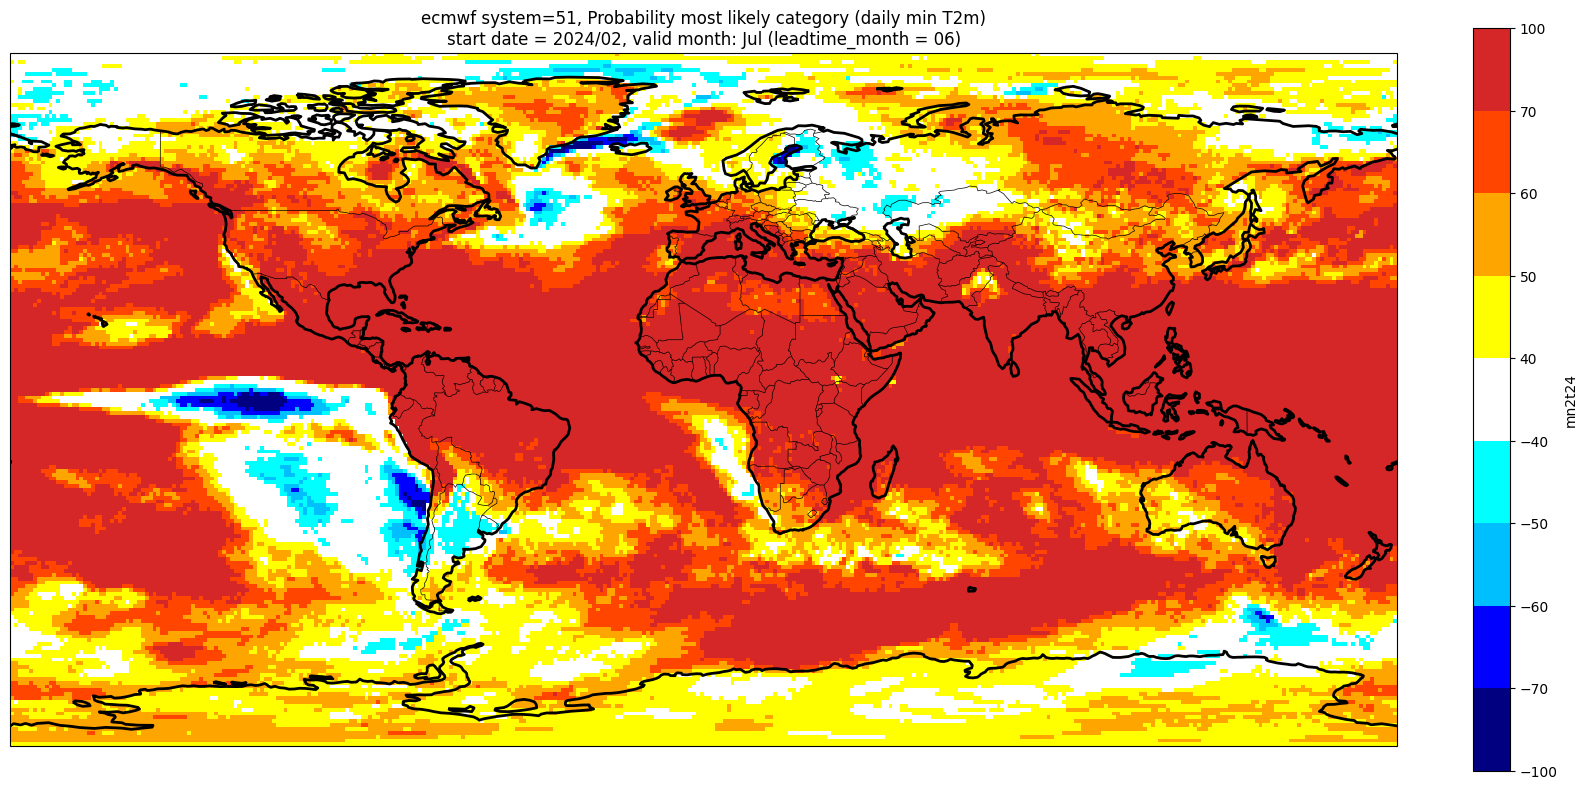

In [35]:
for ltm in lt_mons:
    lt_str = str(ltm).zfill(2)
    plot_data = P_summary.sel(forecastMonth=ltm)  # extract the specific forecast month

    # clip the data to sit within levels range
    plot_data = plot_data.clip(min=-99, max=99)
    
    valid_time = pd.to_datetime(plot_data.valid_time.values)
    vm_str = valid_time.strftime('%b')  # valid month string to label the plot
    title_txt1 = '{} system={}'.format(centre, version) + ', Probability most likely category ({})'.format(var_str)
    title_txt2 = 'start date = {}/{}, valid month: {} (leadtime_month = {})'.format(fc_yr, st_mon, vm_str, lt_str)

    fig = plt.figure(figsize=(16, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.)
    plot_data.plot(levels=contour_levels, colors=contour_colours,
                                               cbar_kwargs={'fraction': 0.033, 'extend': 'neither'})
    plt.title(title_txt1 + '\n' + title_txt2)
    plt.tight_layout()


## Produce ensemble mean anomaly

Here we calculate the ensemble mean anomaly. To create a multi-system ensemble mean anomaly this needs to be done for each system.

In [36]:
hcst_clim = hcst.mean(['start_date', 'number'])  # mean climatology for each lead time for the chosen start
fcst_anom = fcst - hcst_clim
fcst_anom_mean = fcst_anom.mean(['number'])
fcst_anom_mean

<xarray.DataArray 'mn2t24' (forecastMonth: 6, lat: 180, lon: 360)> Size: 2MB
array([[[ 5.8435555e+00,  5.8450460e+00,  5.8465314e+00, ...,
          5.8408370e+00,  5.8414240e+00,  5.8425221e+00],
        [ 5.4541602e+00,  5.4562454e+00,  5.4582152e+00, ...,
          5.4545054e+00,  5.4540286e+00,  5.4533906e+00],
        [ 5.0837092e+00,  5.0856071e+00,  5.0871773e+00, ...,
          5.0727205e+00,  5.0768476e+00,  5.0810809e+00],
        ...,
        [ 9.9170518e-01,  9.8062819e-01,  9.6966404e-01, ...,
          1.0054405e+00,  1.0021384e+00,  9.9881130e-01],
        [ 1.0190047e+00,  1.0174112e+00,  1.0153345e+00, ...,
          1.0173968e+00,  1.0182438e+00,  1.0192608e+00],
        [ 7.2599494e-01,  7.2523648e-01,  7.2437811e-01, ...,
          7.2827595e-01,  7.2749209e-01,  7.2671747e-01]],

       [[ 1.9410343e+00,  1.9393972e+00,  1.9372257e+00, ...,
          1.9482039e+00,  1.9457873e+00,  1.9431790e+00],
        [ 1.8530002e+00,  1.8510718e+00,  1.8492428e+00, ...,
          1.8631986e+00,  1.8595988e+00,  1.8559983e+00],
        [ 1.7578406e+00,  1.7582200e+00,  1.7586147e+00, ...,
          1.7612247e+00,  1.7600017e+00,  1.7583729e+00],
...
        [ 7.9657310e-01,  7.9393393e-01,  7.9108202e-01, ...,
          8.1358725e-01,  8.0704784e-01,  8.0105323e-01],
        [ 6.7678535e-01,  6.7725748e-01,  6.7815447e-01, ...,
          6.6916311e-01,  6.7202818e-01,  6.7478347e-01],
        [ 1.8580657e-01,  1.8689564e-01,  1.8812890e-01, ...,
          1.7871693e-01,  1.8133694e-01,  1.8391927e-01]],

       [[-8.5239783e-03, -8.7878658e-03, -8.8608684e-03, ...,
         -8.0668135e-03, -8.0931420e-03, -8.5167978e-03],
        [-4.0193447e-03, -3.8577809e-03, -4.0175496e-03, ...,
         -3.9086435e-03, -3.7446863e-03, -3.8948806e-03],
        [ 8.3330944e-03,  7.9872282e-03,  7.4732164e-03, ...,
          7.7562518e-03,  8.1266519e-03,  8.4964531e-03],
        ...,
        [ 9.7999066e-01,  9.8089659e-01,  9.8171008e-01, ...,
          9.8080772e-01,  9.8052770e-01,  9.7991407e-01],
        [ 9.5288926e-01,  9.5017076e-01,  9.4739515e-01, ...,
          9.5606816e-01,  9.5519930e-01,  9.5465595e-01],
        [ 7.5614029e-01,  7.5459200e-01,  7.5353193e-01, ...,
          7.5940627e-01,  7.5804853e-01,  7.5703609e-01]]], dtype=float32)
Coordinates:
  * forecastMonth  (forecastMonth) int64 48B 1 2 3 4 5 6
    start_date     datetime64[ns] 8B 2024-02-01
    surface        float64 8B 0.0
  * lat            (lat) float64 1kB 89.5 88.5 87.5 86.5 ... -87.5 -88.5 -89.5
  * lon            (lon) float64 3kB -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
    valid_time     (forecastMonth) datetime64[ns] 48B 2024-02-01 ... 2024-07-01

Save the ensemble mean anomaly for possible future use in other Notebooks.

In [37]:
save_name = '_'.join([var, centre, version, fc_yr, st_mon, 'ensmean_anom.nc'])
fcst_anom_mean.to_netcdf(os.sep.join([data_path, save_name]))

## Plot ensemble mean anomaly

### Plot setup

Note, the level values will need to be updated for variables other than Tmin/Tmax/Tmean.

In [38]:
contour_levels = [-2., -1.5, -1., -0.5, -0.2, 0.2, 0.5, 1.0, 1.5, 2.0]
contour_colours = ["navy", "blue", "deepskyblue", "cyan", "white", "yellow", "orange", "orangered", "tab:red"]
# clip the data to -2 and 2
fcst_anom_mean = fcst_anom_mean.clip(min=-1.99, max=1.99)

### Make a basic plot for one lead month

We plot the ensemble mean anomaly for the first forecast month. Here no significance testing is applied, this will be added in the next step, so this plot is just to demonstrate the difference this makes. 

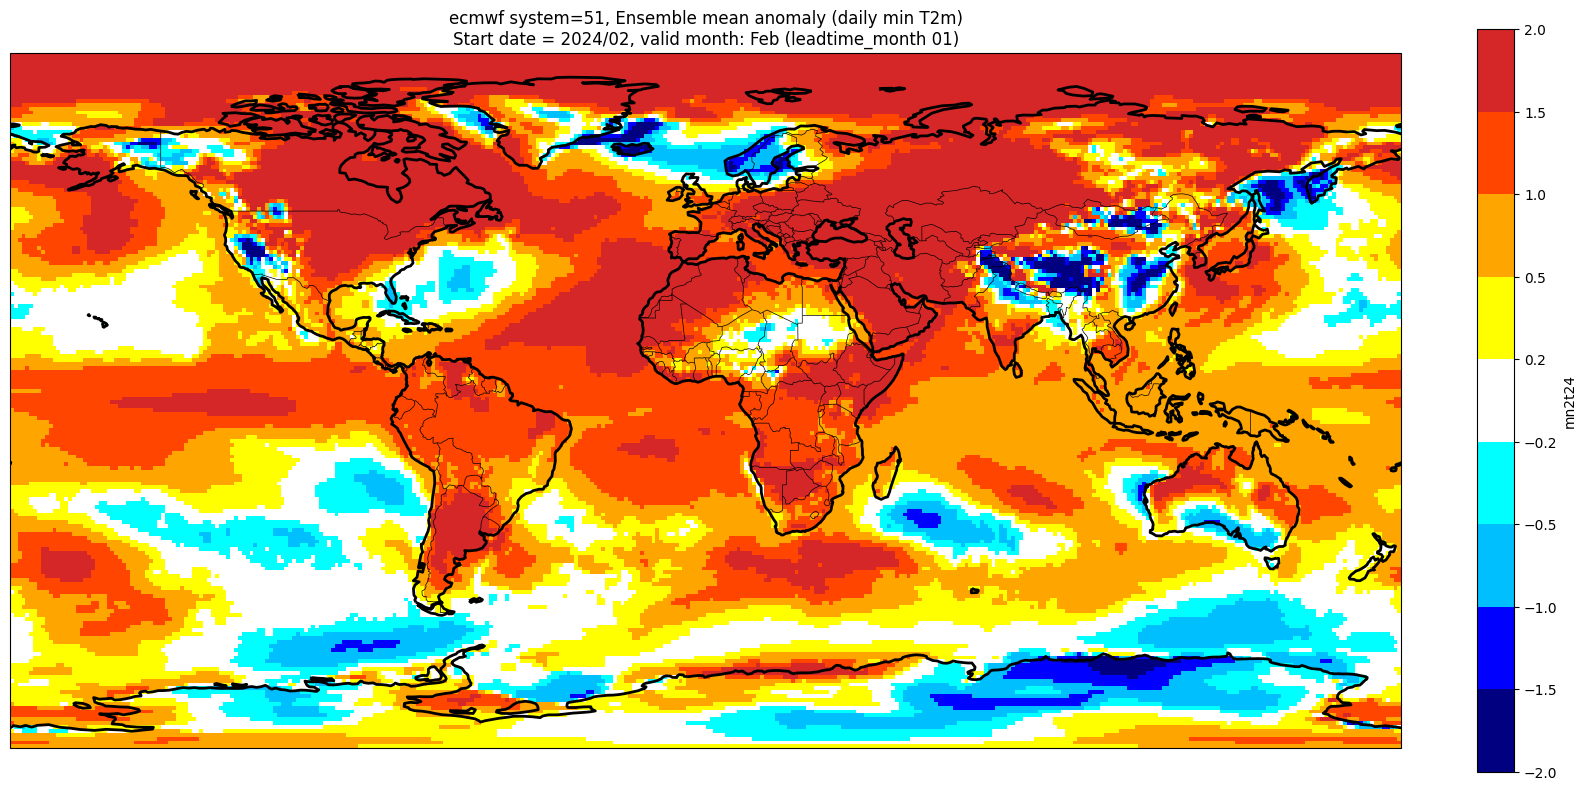

In [39]:
ltm = 1 
lt_str = str(ltm).zfill(2)
plot_data = fcst_anom_mean.sel(forecastMonth=ltm)  # extract the specific forecast month

valid_time = pd.to_datetime(plot_data.valid_time.values)
vm_str = valid_time.strftime('%b')  # valid month string to label the plot
title_txt1 = '{} system={}'.format(centre, version) + ', Ensemble mean anomaly ({})'.format(var_str)
title_txt2 = 'Start date = {}/{}, valid month: {} (leadtime_month {})'.format(fc_yr, st_mon, vm_str, lt_str)

fig = plt.figure(figsize=(16, 8))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.)
plot_data.plot(levels=contour_levels, colors=contour_colours,
                                           cbar_kwargs={'fraction': 0.033, 'extend': 'neither'})
plt.title(title_txt1 + '\n' + title_txt2)
plt.tight_layout()

### Add significance contours and masking 

The single-system ensemble mean plots in the C3S seasonal graphical products also include significance testing, following the approach taken for SEAS5 products (see https://www.ecmwf.int/sites/default/files/medialibrary/2017-10/System5_guide.pdf). Anomaly values below the 10% significance level are masked out, and significance contours are drawn for 1% and 10%. Note, due to the significance testing this cell takes longer to run than the previous one. Note that the colorbar requires customisation to represent the masking in a similar manner to the graphical products.

The first plot may be compared to the plot above, to see the difference.

Flattened forecasts:  (600, 180, 360)
ecmwf system=51, Ensemble mean anomaly (daily min T2m)
Start date = 2024/02, valid month: Feb (leadtime_month 01)
Flattened forecasts:  (600, 180, 360)
ecmwf system=51, Ensemble mean anomaly (daily min T2m)
Start date = 2024/02, valid month: Feb (leadtime_month 02)
Flattened forecasts:  (600, 180, 360)
ecmwf system=51, Ensemble mean anomaly (daily min T2m)
Start date = 2024/02, valid month: Feb (leadtime_month 03)
Flattened forecasts:  (600, 180, 360)
ecmwf system=51, Ensemble mean anomaly (daily min T2m)
Start date = 2024/02, valid month: Feb (leadtime_month 04)
Flattened forecasts:  (600, 180, 360)
ecmwf system=51, Ensemble mean anomaly (daily min T2m)
Start date = 2024/02, valid month: Feb (leadtime_month 05)
Flattened forecasts:  (600, 180, 360)
ecmwf system=51, Ensemble mean anomaly (daily min T2m)
Start date = 2024/02, valid month: Feb (leadtime_month 06)


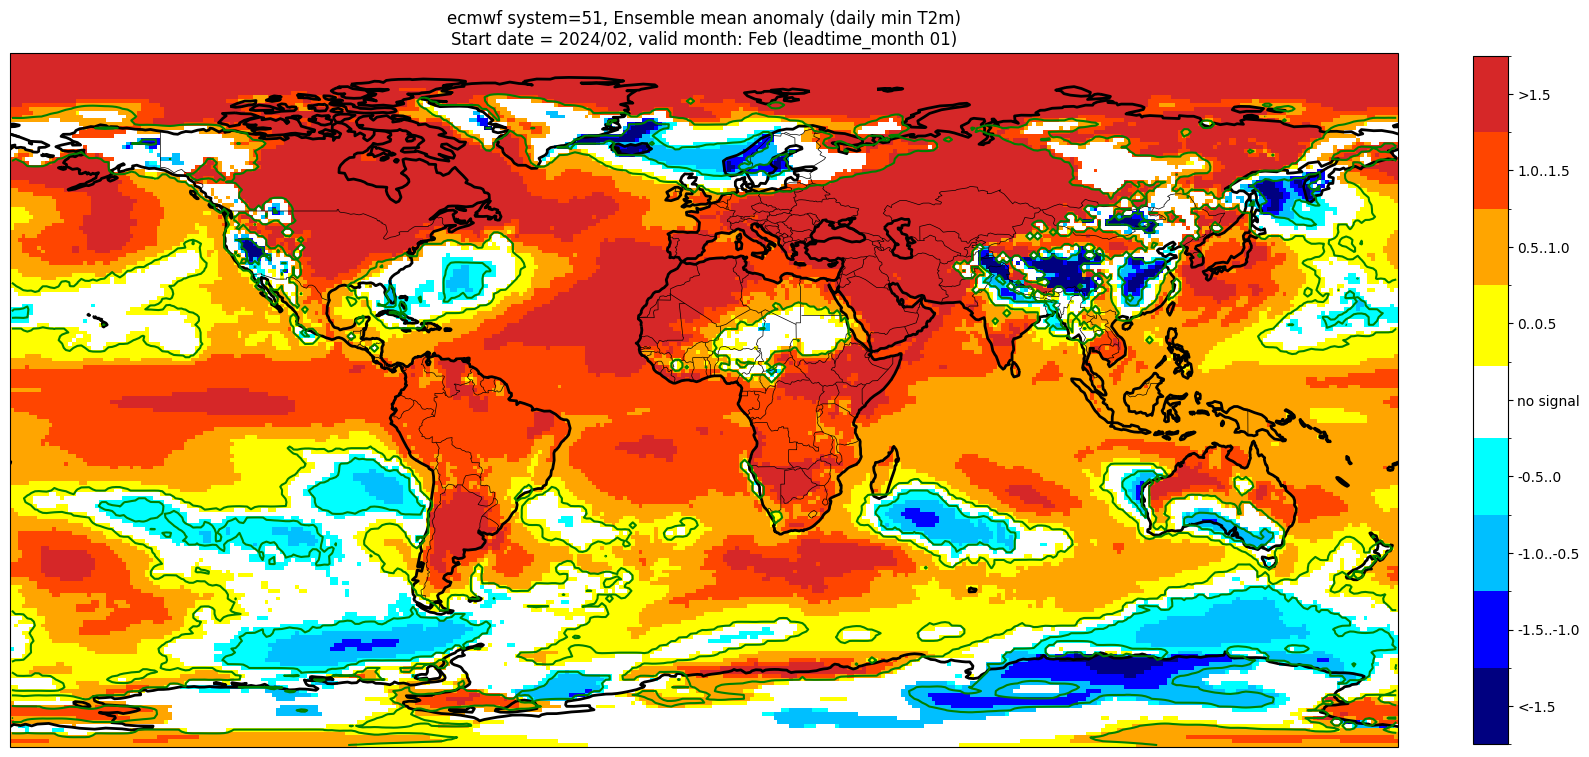

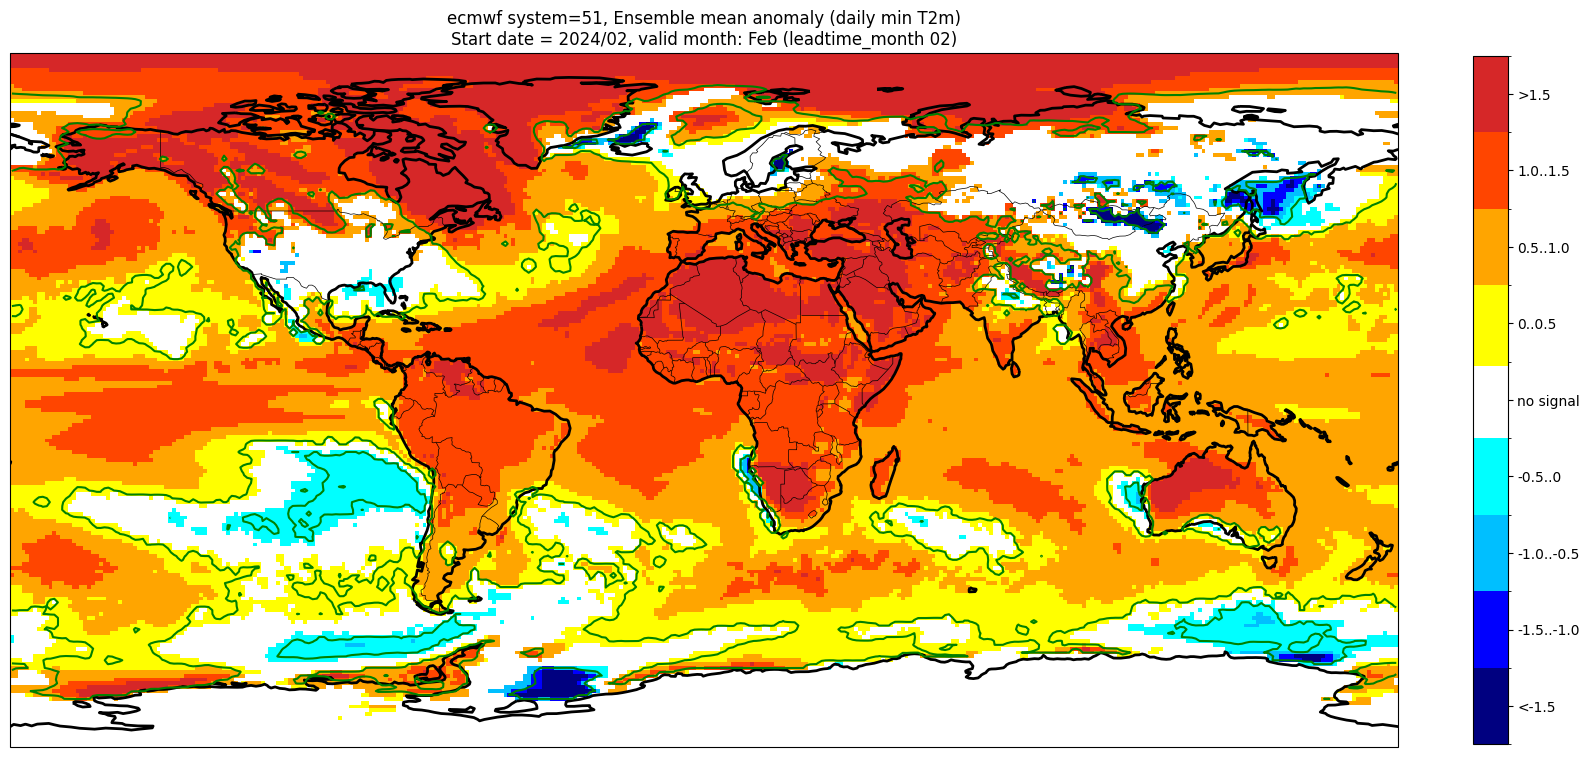

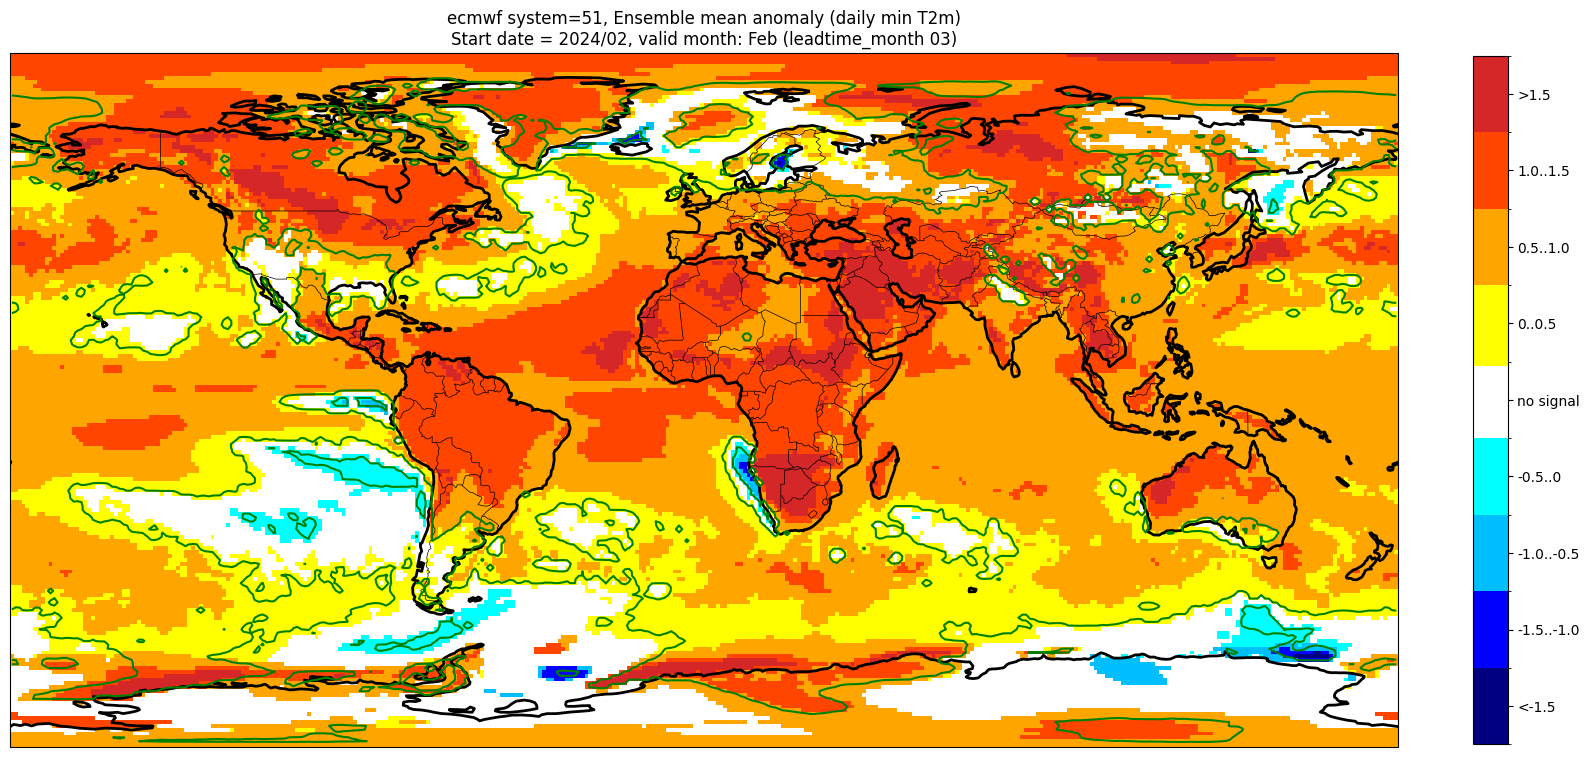

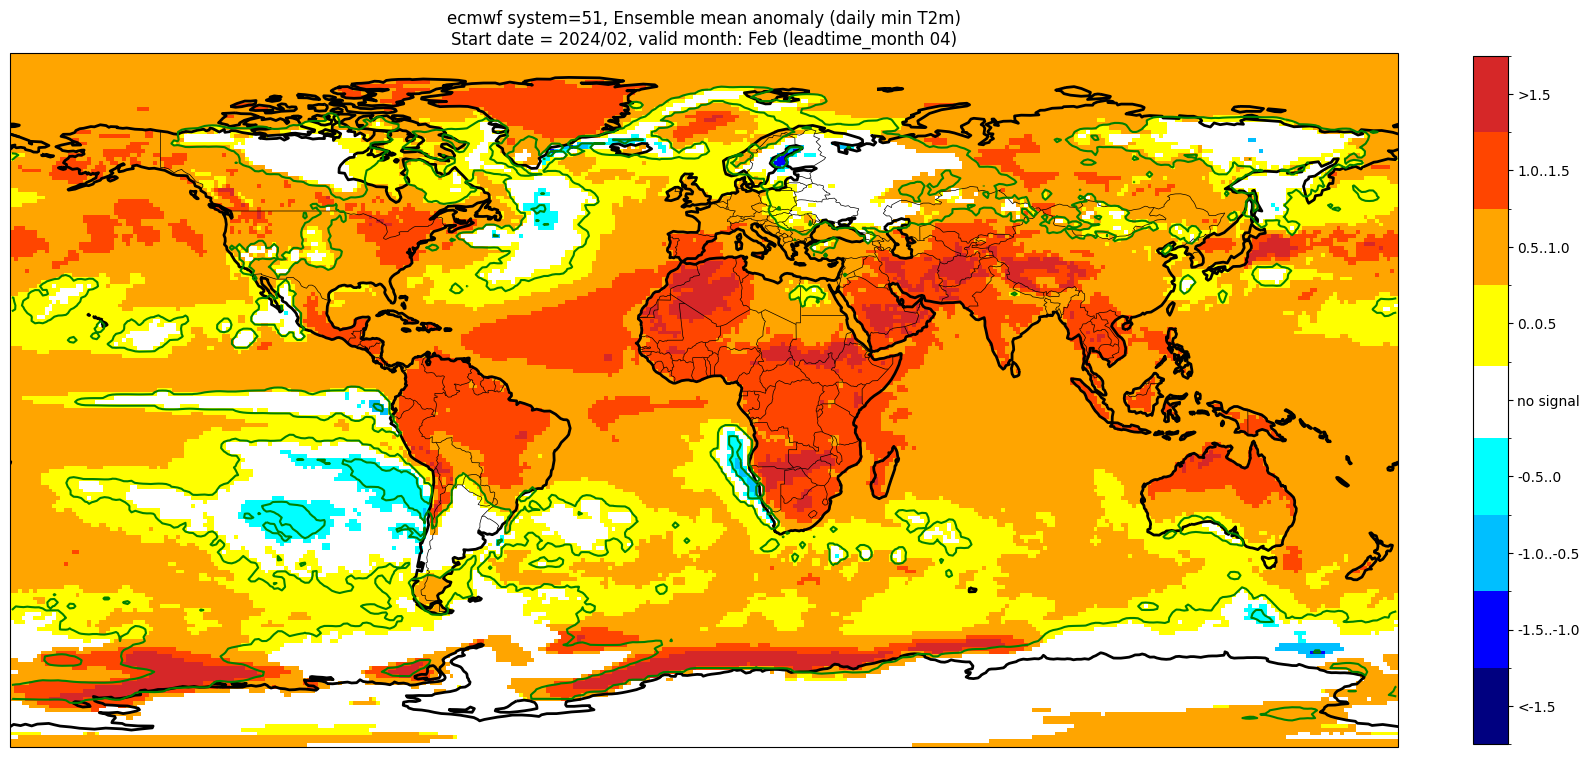

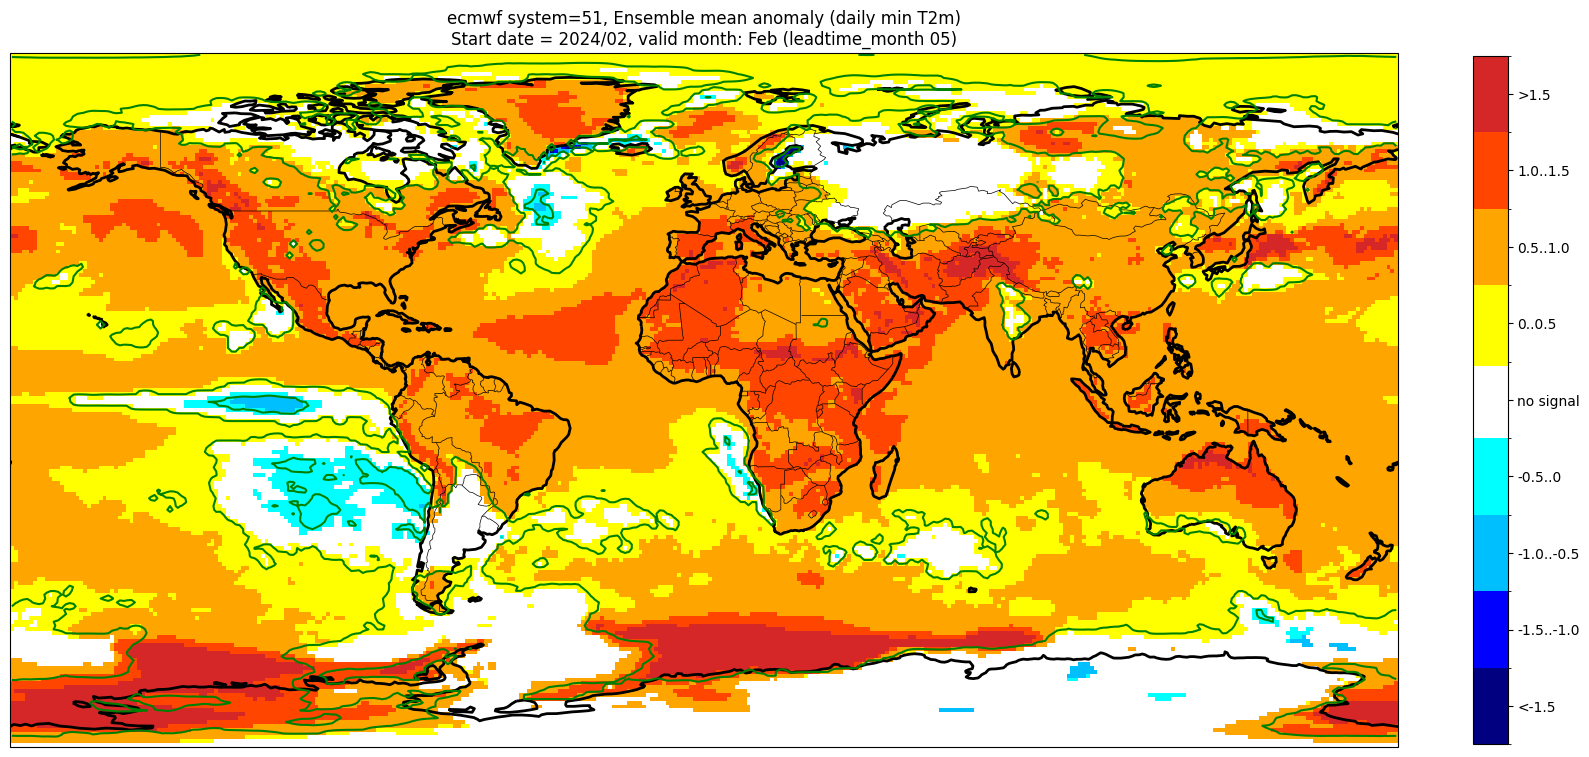

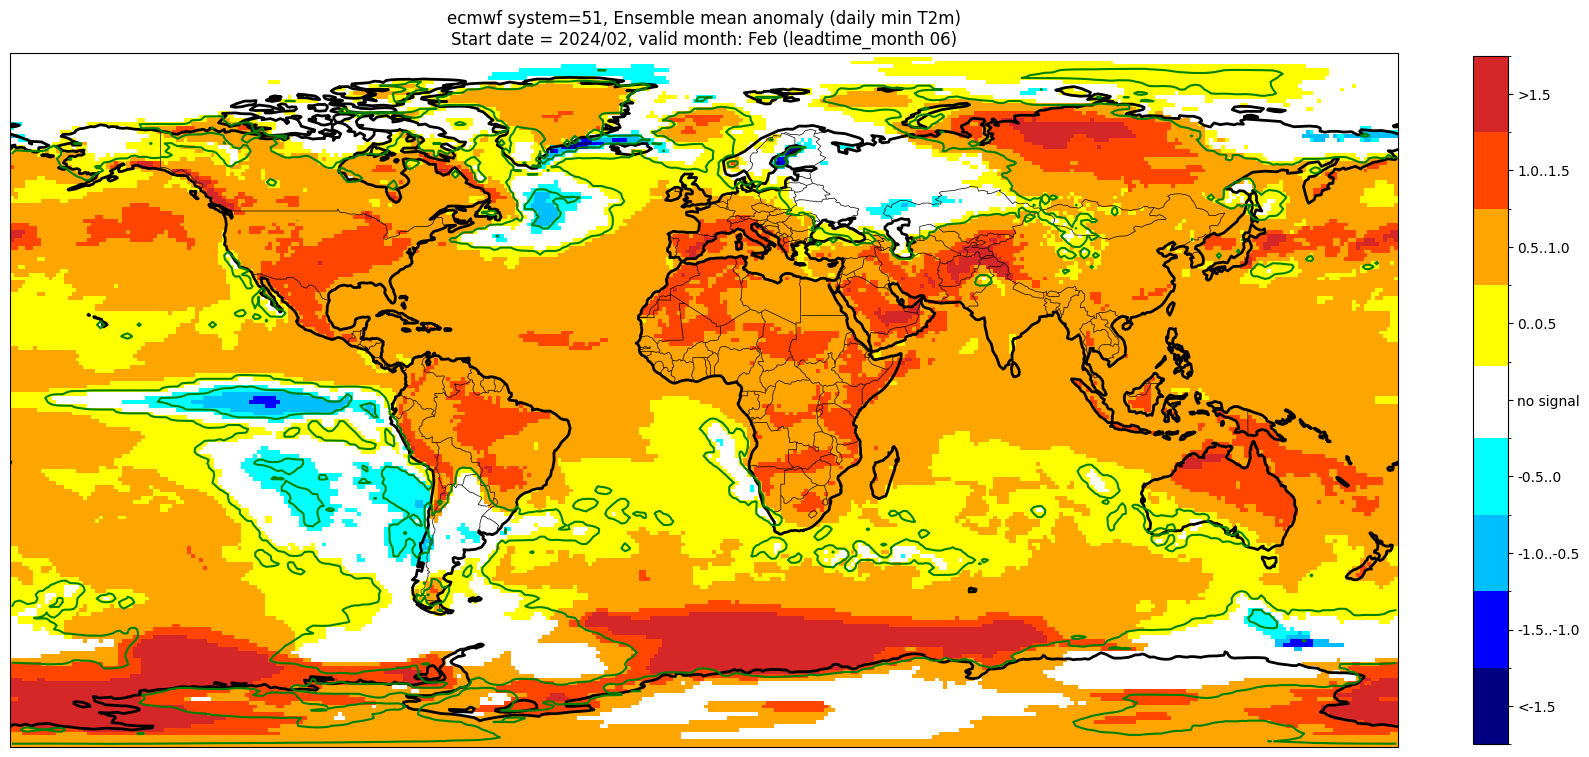

In [40]:
# Function for non-paired rank-sum test
from scipy.stats import mannwhitneyu

# Significance thresholds
pval_thresh_low = 0.1
pval_thresh_high = 0.01

for ltm in lt_mons:
    
    data1 = hcst.sel(forecastMonth=ltm)
    data2 = fcst.sel(forecastMonth=ltm)
 
    # need to flatten number and start date to simply 'samples'
    # proceed in numpy for simplicity
    data1 = data1.data  # includes member and start date
    data2 = data2.data  # includes member

    # flatten sample dimensions
    data1 = data1.reshape(-1, *data1.shape[-2:])  # lat lon are the last dimensions
    print('Flattened forecasts: ', data1.shape)

    # non-paired approach, need to use Mann–Whitney U test
    pvals2 = mannwhitneyu(data1, data2)
    pvals2.pvalue
    
    masked_anom_mean = fcst_anom_mean.sel(forecastMonth=ltm).where(pvals2.pvalue <= 0.1)

    # specific values for Tmax, adjusted to add a dummy white section to label as 'no signal'
    contour_levels = [-2., -1.5, -1., -0.5, -1e-15, 1e-15, 0.5, 1.0, 1.5, 2.0]  # dummy values to plot central white portion in colorbar
    cbar_colours = ["navy", "blue", "deepskyblue", "cyan", "white", "yellow", "orange", "orangered", "tab:red"]
    cbar_labels = ["<-1.5", "-1.5..-1.0", "-1.0..-0.5", "-0.5..0", "no signal", "0..0.5", "0.5..1.0", "1.0..1.5", ">1.5"]
    
    lt_str = str(ltm).zfill(2)
    valid_time = pd.to_datetime(plot_data.valid_time.values)
    vm_str = valid_time.strftime('%b')  # valid month string to label the plot
    title_txt1 = '{} system={}'.format(centre, version) + ', Ensemble mean anomaly ({})'.format(var_str)
    title_txt2 = 'Start date = {}/{}, valid month: {} (leadtime_month {})'.format(fc_yr, st_mon, vm_str, lt_str)
    print(title_txt1)
    print(title_txt2)

    fig = plt.figure(figsize=(16, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
    ax.add_feature(cfeature.COASTLINE, edgecolor='black', linewidth=2.)
    im = masked_anom_mean.plot(levels=contour_levels, colors=cbar_colours, add_colorbar=False)
    cbar = plt.colorbar(im, fraction=0.023, extend='neither', ticks=[-1.75, -1.25, -0.75, -0.25, 0, 0.25, 0.75, 1.25, 1.75])
    cbar.ax.set_yticklabels(cbar_labels)
    plt.contour(masked_anom_mean.lon.values, masked_anom_mean.lat.values, pvals2.pvalue, levels=[0.01], colors='green')
    plt.title(title_txt1 + '\n' + title_txt2)
    plt.tight_layout()

These plots are similar to the monthly C3S graphical products. Note that here we have plotted the first month of the forecast (February, or leadtime_month = 1), while in the graphical products we show the monthly forecasts starting with the month following the release month (which would be March in this case). The three-month aggregations shown in the graphical products could be created in a similar manner, by combining the corresponding monthly means, and then proceeding as above.